In [86]:
import numpy as np
import matplotlib.pyplot as plt
import heat
%pylab inline
%load_ext autoreload  
%autoreload 2
from scipy import ndimage
#from scipy.interpolate import interpn
#from transformations import *  # handy set of rotation routines!!!!
matplotlib.rcParams.update({'font.size': 20})
from transformations import *  # handy set of rotation routines!!!!

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# notes currently
# x,y from xrot yrot output, not body coords

In [88]:
# using transformations.py
# stack point positions into a matrix so can call
# transformations on it
#xarr,yarr,zarr are 1d arrays all same length  
def v_stack(xarr,yarr,zarr):
    warr = xarr*0.0 + 1.0
    v0 = np.array([xarr,yarr,zarr,warr] , dtype=numpy.float64)
    return v0

def un_v_stack(v0):
    xarr = np.copy(np.array(v0[0]))
    yarr = np.copy(np.array(v0[1]))
    zarr = np.copy(np.array(v0[2]))
    return xarr,yarr,zarr

# here xarr0,yarr0,zarr0 are 1d arrays all same length first set of points
# and likewise xarr1,yarr1,zarr1 for second set
# find transformation rotation between two sets of points
def mytrans_points(xarr0,yarr0,zarr0,xarr1,yarr1,zarr1):
    v0 = v_stack(xarr0,yarr0,zarr0)  #first point set
    v1 = v_stack(xarr1,yarr1,zarr1)  #second point set
    M = superimposition_matrix(v0, v1)
    return M # transformation matrix!  M is a 4 d matrix

# apply the transformation M to a set of points
# return the transformed vectors
def applyM(M,xarr,yarr,zarr):
    v0 = v_stack(xarr,yarr,zarr)
    v1try = numpy.dot(M, v0)  # rotate by M
    xarrnew,yarrnew,zarrnew = un_v_stack(v1try)
    return xarrnew,yarrnew,zarrnew 


# I want to rotate from one vector to another
# return rotation matrix made from quaternion
#q.w = sqrt((v1.Length ^ 2) * (v2.Length ^ 2)) + dotproduct(v1, v2);
#quaternion_matrix(quaternion):
#    """Return homogeneous rotation matrix from quaternion.
# rotates v1 to v2
def retMq(v1x,v1y,v1z,v2x,v2y,v2z):
    v1s = np.array([v1x,v1y,v1z])/np.sqrt(v1x*v1x + v1y*v1y + v1z*v1z)
    v2s = np.array([v2x,v2y,v2z])/np.sqrt(v2x*v2x + v2y*v2y + v2z*v2z)
    vcross = numpy.cross(v1s,v2s)
    qw = np.sqrt(numpy.dot(v1s,v1s)*numpy.dot(v2s,v2s)) + numpy.dot(v1s,v2s)
    qx = vcross[0]; qy = vcross[1]; qz = vcross[2]
    ql = np.sqrt(qx*qx + qy*qy + qz*qz + qw*qw)
    qq = np.array([qw,qx,qy,qz])/ql # quaternion
    #print(vcross)
    #print(qq)
    Mq= quaternion_matrix(qq)
    #print(Mq)
    return Mq  # returns rotation vector 
    
    # how to test it!
    #v1x = np.sin(0.2);v1y = np.cos(0.2); v1z = 0.0
    #v2x = np.sin(0.4);v2y = 0.0; v2z = np.cos(0.4)
    #Mq = retMq(v1x,v1y,v1z,v2x,v2y,v2z)
    #print(Mq)

    #x,y,z = applyM(Mq,np.array([v1x]),np.array([v1y]),np.array([v1z]))
    #print(x,y,z)
    #print(v2x,v2y,v2z)
    # this seems to work!
    

In [3]:
# make a file name for code outputs, can be used to make heat file names too
def nodefilename(froot,suffix,index):
    num1 = '{0:d}'.format(index)
    ff = froot + '_'
    if (index < 100000):
        ff = ff + '0'
    if (index < 10000):
        ff = ff + '0'
    if (index < 1000):
        ff = ff + '0'
    if (index < 100):
        ff = ff + '0'
    if (index < 10):
        ff = ff + '0'
    ff = ff + num1 + suffix
    print(ff)
    return ff

# for testing
#froot = '../heat_s18/a1'; suffix = '_node.txt'
#nfile = nodefilename(froot,suffix,6)
#print(nfile); #../heat_s18/a1_000006_node.txt


In [4]:
# return a meshgrid and linspaces and actual spacing dx_actual
def mkgrid(dx,xmax):
    #dy = dx
    xmin = -xmax;
    ymax = xmax; ymin = -ymax;
    nx = np.int((xmax-xmin)/dx) + 1;
    ny = nx
    xlinsp = np.linspace(xmin,xmax,nx)
    ylinsp = np.linspace(ymin,ymax,ny)
    yarrh,xarrh = np.meshgrid(ylinsp,xlinsp)  #nontrivial order here, is flipped
    #xarrh[i,*] gives x depending on i and is all the same for second index
    dx_actual = xlinsp[1]- xlinsp[0]  # dx is not exact
    return dx_actual,xlinsp,yarrh,xarrh

# lat lon grids
def mklatlongrid(dphi):  # returns phigrid [-pi,pi], thetagrid [-pi/2,pi/2]
    phimin = -np.pi
    phimax =  np.pi
    thetamin = -np.pi/2.
    thetamax =  np.pi/2.
    nth  = int((thetamax - thetamin)/dphi) + 1
    nphi = int((phimax   - phimin)  /dphi) + 1
    philinsp = np.linspace(phimin,phimax,nphi)
    thetalinsp = np.linspace(thetamin,thetamax,nth)
    parrh,tarrh = np.meshgrid(philinsp,thetalinsp)  # x,y but indexing is j,i
    return thetalinsp,philinsp,tarrh,parrh

#thetalinsp,philinsp,tarrh,parrh = mklatlongrid(0.1) test

# lat lon grids
def mkmulongrid(dphi):  # returns phigrid [-pi,pi], mugrid [-1,1]
    phimin = -np.pi
    phimax =  np.pi
    mumin = -1.0  # is sin theta
    mumax =  1.0
    nphi = int((phimax - phimin)/dphi) + 1
    nmu  = int(nphi/2)
    philinsp = np.linspace(phimin,phimax,nphi)
    mulinsp = np.linspace(mumin,mumax,nmu)
    parrh,marrh = np.meshgrid(philinsp,mulinsp)  # x,y but indexing is j,i
    return mulinsp,philinsp,marrh,parrh

In [116]:
#   passing xarr,yarr,zarr coordinate arrays
#   heat array is harr
#   summing those within a distance of z midplane 
#   use Gaussian weighting as a function of distance from plane, sigz
#   binning uses dx and xmax to make grid
#       integral of  e^-x^2 is sqrt pi
def heatxysig(xarr,yarr,zarr,harr,dx,xmax,sigz,nrand):
    dx_actual,xlinsp,yarrh,xarrh = mkgrid(dx,xmax)    # grid
    pixarea =  dx_actual**2; 
    mhist = xarrh*0.0;
    mrhist = xarrh*0.0;
    whist = xarrh*0.0;
    poff = 0.0;  # pixel offset
    rarr = np.sqrt(xarr**2 + yarr**2 + zarr**2)
    fac = 1.0/np.sqrt(2.0*np.pi) * (1.0/sigz) # for normalization of z part
    fac = fac/nrand/pixarea
    n = np.size(xarr);
    for i in range (0,n):  # loop over particles
        if (np.abs(zarr[i]) < 3*sigz):
            for k in range(nrand):
                xg = xarr[i] 
                yg = yarr[i] 
                zg = zarr[i] 
                if (nrand >1):
                    xg += np.random.normal(0.0,dx_actual/2)
                    yg += np.random.normal(0.0,dx_actual/2)
                    zg += np.random.normal(0.0,dx_actual/2) 
                zg2 = 0.5*(zg/sigz)**2  # is positive
                weight = np.exp(-zg2) # gaussian weight
                xi = np.int((xg - np.min(xlinsp))/dx_actual + poff);
                yi = np.int((yg - np.min(xlinsp))/dx_actual + poff);
                if ((xi >=0) and (xi<np.size(xlinsp))):
                    if ((yi >=0) and (yi<np.size(xlinsp))):
                        mhist[xi,yi]+= weight*harr[i]  # sumk with weights via z
                        mrhist[xi,yi]+= weight*harr[i]*rarr[i]  # T*r
                        # mrhist weights heating by r
                        #checked order!
                        whist[xi,yi]+= weight; 
    mhist = mhist*fac  # normalize heat/volume                    
    #jj = np.where(whist >0.0)
    #mhist[jj] = mhist[jj]/whist[jj]
    #mhist = mhist/whist
    #mrhist = mrhist/whist
    return xarrh,yarrh,mhist,mrhist   # note order

# trying to make a lat lon heatmap, 
# pshift allows you to shift phi
# phitilt,itilt let you tilt to correct for a tilt
# gives heat per unit area
def latlon_heat(xarr,yarr,zarr,harr,dphi,rmin,sigd,nrand,pshift,phitilt,itilt):
    v1x = np.sin(itilt)*np.cos(phitilt); v1y = np.sin(itilt)*np.sin(phitilt)
    v1z = np.cos(itilt)
    Mq = retMq(v1x,v1y,v1z,0,0,1)
    xarr_n,yarr_n,zarr_n = applyM(Mq,xarr,yarr,zarr)
    
    thetalinsp,philinsp,tarrh,parrh = mklatlongrid(dphi) 
    rarr = np.sqrt(xarr**2 + yarr**2 + zarr**2)
    phiarr = np.arctan2(yarr_n,xarr_n)  + pshift
    jj = np.where(phiarr>np.pi)
    phiarr[jj] -= 2.0*np.pi
    jj = np.where(phiarr>np.pi)
    phiarr[jj] -= 2.0*np.pi
    latarr = np.arcsin(zarr_n/rarr)   
    dphi_actual = philinsp[1]-philinsp[0]
    dtheta_actual = thetalinsp[1]-thetalinsp[0]
    hhist = tarrh*0.0
    n = np.size(xarr);
    nrand_ac = nrand
    if (nrand<1):
        nrand_ac=1
    for i in range (0,n):  # loop over particles
        for j in range(0,nrand_ac):
            x = xarr_n[i] + np.random.normal(0.0,sigd)
            y = yarr_n[i] + np.random.normal(0.0,sigd)
            z = zarr_n[i] + np.random.normal(0.0,sigd)
            rr = np.sqrt(x*x + y*y + z*z)
            theta = np.arcsin(z/rr) # latitude [-pi/2,pi/2]
            phi = np.arctan2(y,x)+pshift # longitude [-pi,pi]
            if (phi >= np.pi):
                phi -= 2.0*np.pi
            if (phi <= -np.pi):
                phi += 2.0*np.pi
            ip = int((phi - np.min(philinsp))/dphi_actual)
            it = int((theta - np.min(thetalinsp))/dtheta_actual)
            if (((rr > rmin) and (ip>=0)) and (it >=0)):
                hhist[it,ip] += harr[i]/nrand_ac  # yx indexing
    nnp = np.size(philinsp)
    nnt = np.size(thetalinsp)
    hhist[:,nnp-1] = hhist[:,0]
    hhist[nnt-1,:] = hhist[0,:]
    # now probably should multiply each pixel by its area?
    # do we want heat per unit area?
    #muarrh = np.cos(tarrh) + np.cos(np.pi/2 - dtheta_actual)
    area = thetalinsp*0.0
    for i in range(0,nnt-1):
        area[i] = ( np.sin(thetalinsp[i+1]) - np.sin(thetalinsp[i]) )*dphi_actual
    area[nnt-1] = area[0]
    #print(area)
    for j in range(0,nnp):
        hhist[:,j] /= area  #yes we have heat per unit area on surface
    return tarrh,parrh,hhist



In [278]:
# makes heat per unit area lat long map for a consecutive list of output files
def plt_heat_ll_img(froot,index,di,dphi,rmin,sigd,nrand,nsmo,ofile,pshift,phitilt,itilt):
    suffix = '_heat.txt'
    if (di<=0):
        print("plt_heat_ll: di<=0!!! no data")
    thetalinsp,philinsp,tarrh,parrh = mklatlongrid(dphi) 
    hsum = parrh*0.0
    for i in range(0,di):
        nfile = nodefilename(froot,suffix,index+i)
        iarr,xarr,yarr,zarr,dedt,xrot,yrot = \
            np.loadtxt(nfile, skiprows=2, unpack=True)
        tarrh,parrh,hhist=latlon_heat(xrot,yrot,zarr,dedt,dphi,\
                                      rmin,sigd,nrand,pshift,phitilt,itilt)
        hsum += hhist/di
    return hsum

# take latlon heat map and output a pretty figure, some smoothing
# input hsum is the result of computing lat lon heat in previous routine
# if ptype ==1 then plot divided by mean
# if ptype ==0 then plot sub mean divided by std
def plt_heat_ll(hsum,froot,index,di,dphi,rmin,sigd,nrand,nsmo,ptype,mylabel,ofile):
    thetalinsp,philinsp,tarrh,parrh = mklatlongrid(dphi) 
    # here tarrh is latitude array [-pi/2, pi/2]
    f, axarr = plt.subplots(1,1,sharex=True,sharey=True,figsize=(8.5,5));
    f.subplots_adjust(hspace=0);
    f.subplots_adjust(wspace=0.05);
    f.subplots_adjust(left=0.13)
    f.subplots_adjust(right=0.85)
    f.subplots_adjust(bottom=0.15)
    f.subplots_adjust(top=0.95)
    axarr.set_xlabel('longitude')
    axarr.set_ylabel('latitude')
    axarr.set_yticks([-np.pi/2,0,np.pi/2])
    axarr.set_yticklabels([r'-$\pi$/2','0',r'$\pi$/2'], minor=False)
    axarr.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
    axarr.set_xticklabels([r'-$\pi$',r'-$\pi$/2','0',r'$\pi$/2',r'$\pi$'], minor=False)
    
    img = ndimage.gaussian_filter(hsum,[nsmo,2*nsmo])
    forave = np.cos(tarrh) # over integrations over sphere
    ave_all = np.sum(img*forave)/np.sum(forave) # this is now averaged via integration over sphere!!!!!
    sig2_all = np.sum((img - ave_all)**2*forave)/np.sum(forave)
    sig_all = np.sqrt(sig2_all)
    if (ptype ==0):
        imgshow= (img - ave_all)/sig_all
        dlev = 0.4
        max_all =vnp.max(np.max(imgshow))
        min_all = np.min(np.min(imgshow))
    if (ptype ==1):
        imgshow= img/ave_all
        dlev = 0.2
        max_all = 2.4 # np.max(np.max(imgshow))
        min_all = 0.4 # np.min(np.min(imgshow))
    
    #mcolors = 'plasma'
    #mcolors = 'PuOr'
    #mcolors = 'gist_stern'
    mcolors ='brg'
    imgp=axarr.pcolormesh(parrh,tarrh,imgshow,vmin=min_all,vmax=max_all,cmap=mcolors)
    
    
    levmax = dlev*int(max_all/dlev) + dlev
    levmin = dlev*int(min_all/dlev)
    levels = np.arange(levmin, levmax, dlev)
    #print(levels)
    CS = axarr.contour(parrh,tarrh,imgshow, levels,colors='white')
   
    ii = np.argmin( np.fabs(levels - 1.0))
    #print(ii)
    shortlev = (levels[ii],levels[ii+2])
    #print(shortlev)
    axarr.clabel(CS, shortlev, inline=1, fmt='%1.1f', fontsize=14) #
    
    cbar_ax = f.add_axes([0.860, 0.17, 0.03, 0.75])
    cbar = f.colorbar(imgp, cax=cbar_ax,format='%.1f',ticks = levels)
    #f.colorbar(CS, cax=cbar_ax,format='%.1f')
    cbar.add_lines(CS)
    if (len(mylabel)>1):
        axarr.text(-np.pi+0.1,np.pi/2-0.24,mylabel,fontsize=22,color='black',weight='heavy')
    
    if (len(ofile)>2):
        plt.savefig(ofile)
        
def plt3_heat(froot,index,di,dx,sigz,multr,xmax,nsmo,xyfac,pshift,phitilt,itilt,mylabel,ofile):
    nrand=1
    #nsmo =0.5
    suffix = '_heat.txt'
    dx_actual,xlinsp,yarrh,xarrh = mkgrid(dx,xmax)   
    mhist_a = 0*xarrh
    mhist_b = 0*xarrh
    mhist_c = 0*xarrh
    if (di==0):
        print("plt3_heat: di==0!!! no data")
        
    v1x = np.sin(itilt)*np.cos(phitilt); v1y = np.sin(itilt)*np.sin(phitilt)
    v1z = np.cos(itilt)
    Mq = retMq(v1x,v1y,v1z,0,0,1)  # to slightly tilt by obliquity
    
    for i in range(0,di):
        nfile = nodefilename(froot,suffix,index+i)
        iarr,xarr,yarr,zarr,dedt,xrot,yrot = \
            np.loadtxt(nfile, skiprows=2, unpack=True)
        xarr_n0,yarr_n0,zarr_n = applyM(Mq,xrot,yrot,zarr)
        xarr_n = xarr_n0*np.cos(pshift) - yarr_n0*np.sin(pshift)
        yarr_n = xarr_n0*np.sin(pshift) + yarr_n0*np.cos(pshift)
        xarrh_a,yarrh_a,mhist_ai,mrhist_a  = \
            heatxysig(xarr_n,yarr_n,zarr_n,dedt,dx,xmax,sigz,nrand)
        xarrh_b,zarrh_b,mhist_bi,mrhist_b  = \
            heatxysig(xarr_n,zarr_n,yarr_n,dedt,dx,xmax,sigz,nrand)
        yarrh_c,zarrh_c,mhist_ci,mrhist_c  = \
            heatxysig(yarr_n,zarr_n,xarr_n,dedt,dx,xmax,sigz,nrand)
        mhist_a += mhist_ai
        mhist_b += mhist_bi
        mhist_c += mhist_ci
    if (di >0):
        mhist_a /= di
        mhist_b /= di
        mhist_c /= di
        
    #rarr0=np.sqrt(xarr0**2 + yarr0**2 + zarr0**2)
    
    f, axarr = plt.subplots(1,3,sharex=True,sharey=True,figsize=(8.5,3));
    f.subplots_adjust(hspace=0);
    f.subplots_adjust(wspace=0.05);
    f.subplots_adjust(left=0.07)
    f.subplots_adjust(right=0.80)

    plt.setp([a.get_xticklabels() for a in f.axes], visible=False) ;
    plt.setp([a.get_yticklabels() for a in f.axes], visible=False) ;
    plt.setp(axarr[0].get_xticklabels(), visible=True) ;
    plt.setp(axarr[0].get_yticklabels(), visible=True) ;
    axarr[0].set_xlim([-xmax,xmax])
    axarr[0].set_ylim([-xmax,xmax])
    for i in range(0,3):
        axarr[i].set_aspect(1.0);
        axarr[i].set_adjustable('box-forced')

    img_a = ndimage.gaussian_filter(mhist_a,nsmo)
    img_b = ndimage.gaussian_filter(mhist_b,nsmo)
    img_c = ndimage.gaussian_filter(mhist_c,nsmo)
    max_all = np.max([np.max(img_a),np.max(img_b), np.max(img_c)])
    img=axarr[0].pcolormesh(xarrh_a,yarrh_a,img_a,vmin=0,vmax=max_all*xyfac,cmap='inferno')
    img=axarr[1].pcolormesh(xarrh_a,yarrh_a,img_b,vmin=0,vmax=max_all,cmap='inferno')
    img=axarr[2].pcolormesh(xarrh_a,yarrh_a,img_c,vmin=0,vmax=max_all,cmap='inferno')
    
    for i in range(0,3):
        axarr[i].plot((0),(0),'r+')

    cbar_ax = f.add_axes([0.81, 0.17, 0.03, 0.68])
    f.colorbar(img, cax=cbar_ax,format='%.1e')
    d1=0.07; v1=0.05;
    d2=0.07; v2=0.09;
    pm = xmax;
    xyzcolor='lightgreen'
    axarr[0].text( pm-d1,-pm+v1,'x',ha='center',va='bottom',fontsize=16,color=xyzcolor);
    axarr[0].text(-pm+d2, pm-v2,'y',ha='left',va='center',fontsize=16,color=xyzcolor);
    axarr[1].text( pm-d1,-pm+v1,'x',ha='center',va='bottom',fontsize=16,color=xyzcolor);
    axarr[1].text(-pm+d2, pm-v2,'z',ha='left',va='center',fontsize=16,color=xyzcolor);
    axarr[2].text( pm-d1,-pm+v1,'y',ha='center',va='bottom',fontsize=16,color=xyzcolor);
    axarr[2].text(-pm+d2, pm-v2,'z',ha='left',va='center',fontsize=16,color=xyzcolor);
    if (len(mylabel)>1):
        axarr[0].text(-1.05,-1,mylabel,fontsize=16,color='white')
    
    if (len(ofile) > 2):
        plt.savefig(ofile)



In [12]:
# for all figures
# these for heat slices
xmax = 1.1   # display range for heat equatorial slices
sigz = 0.20  # width of slice
dx = 0.08    # pixel width  
nsmo_plt3=1  # smoothing for heat slices
# these for latlon plots
dphi=0.1     # approx pixel size in phi in radians
rmin=0.5     # discard points within this radius
nsmo=1.0     # some smoothing
sigd=0.1     # add some random offsets in particle positions
nrand=2      # how many random offsets
dir_root = '../moon_heat3/'
try_root = '_3_'

../moon_heat3/m2_out/m2_000007_heat.txt


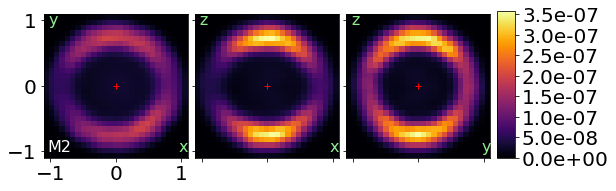

In [224]:
run = 'm2'
froot = dir_root + run + '_out/' + run  
index=7
di = 1 # number of code outputs to use
plt3_heat(froot,index,di,dx,sigz,0,xmax,nsmo_plt3,0.8,0,0,0, 'M2',run + try_root + 'heatxyz.png')

../moon_heat3/m2_out/m2_000009_heat.txt
../moon_heat3/m2_out/m2_000010_heat.txt


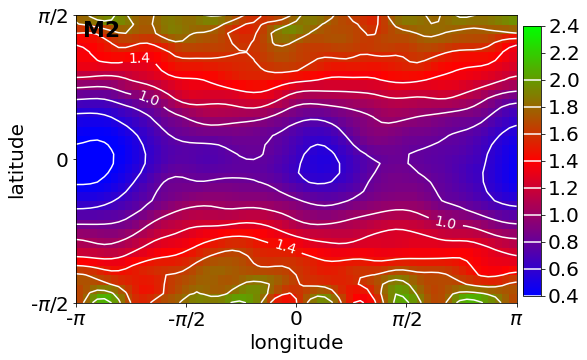

In [279]:
run = 'm2'
froot = dir_root + run + '_out/' + run  
#froot = '../moon_heat2/n1_out/n1'; 
index=9
di=2       # number of code outputs to use
img_m2=plt_heat_ll_img(froot,index,di,dphi,rmin,sigd,nrand,nsmo,'',-0.1,0,0.0)
plt_heat_ll(img_m2,froot,index,di,dphi,rmin,sigd,nrand,nsmo, 1,'M2',run + try_root + '_ll.png')

../moon_heat3/m3_out/m3_000009_heat.txt


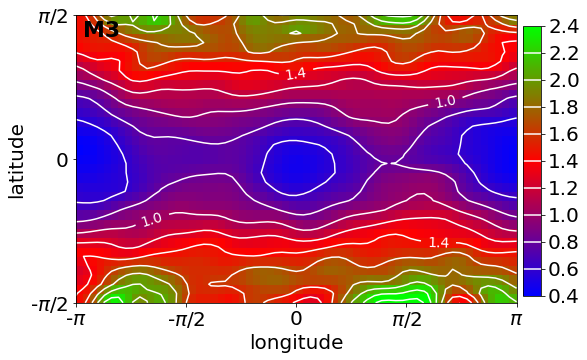

In [280]:
run = 'm3'
froot = dir_root + run + '_out/' + run  
#froot = '../moon_heat2/n1_out/n1'; 
index=9
di=1       # number of code outputs to use
img_m2=plt_heat_ll_img(froot,index,di,dphi,rmin,sigd,nrand,nsmo,'',0.5,0,0.0)
plt_heat_ll(img_m2,froot,index,di,dphi,rmin,sigd,nrand,nsmo,1,'M3',run + try_root + '_ll.png')

../moon_heat3/m4_out/m4_000011_heat.txt


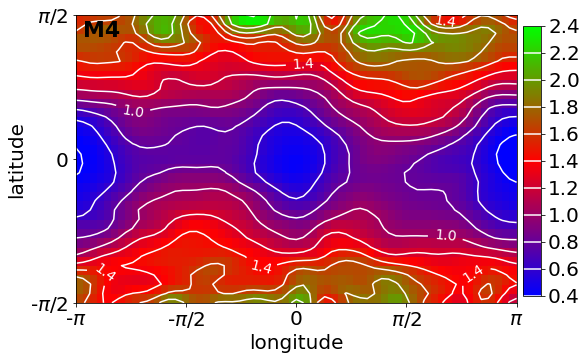

In [281]:
run = 'm4'
froot = dir_root + run + '_out/' + run  
#froot = '../moon_heat2/n1_out/n1'; 
index=11
di=1       # number of code outputs to use
img_m2=plt_heat_ll_img(froot,index,di,dphi,rmin,sigd,nrand,nsmo,'',0.1,0,-0.00)
plt_heat_ll(img_m2,froot,index,di,dphi,rmin,sigd,nrand,nsmo,1, 'M4',run + try_root + '_ll.png')

../moon_heat3/m1_out/m1_000008_heat.txt


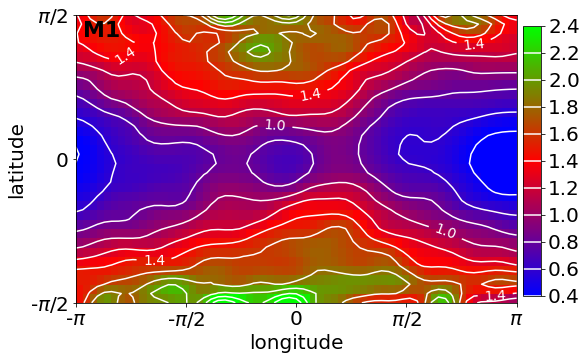

In [282]:
run = 'm1'
froot = dir_root + run + '_out/' + run  
#froot = '../moon_heat2/n1_out/n1'; 
index=8
di=1       # number of code outputs to use
img_m2=plt_heat_ll_img(froot,index,di,dphi,rmin,sigd,nrand,nsmo,'',0.2,0,-0.00)
plt_heat_ll(img_m2,froot,index,di,dphi,rmin,sigd,nrand,nsmo, 1,'M1',run + try_root + '_ll.png')

../moon_heat3/o2_out/o2_000012_heat.txt


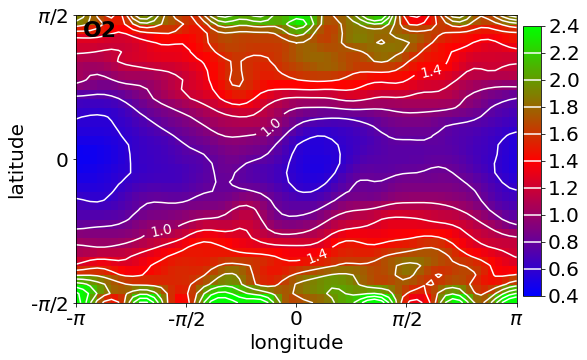

In [283]:
run = 'o2'
froot = dir_root + run + '_out/' + run  
index=12
di=1       # number of code outputs to use
img_m2=plt_heat_ll_img(froot,index,di,dphi,rmin,sigd,nrand,nsmo,'',0.2,0,-0.00)
plt_heat_ll(img_m2,froot,index,di,dphi,rmin,sigd,nrand,nsmo, 1,'O2',run + try_root + '_ll.png')

../moon_heat3/o2_out/o2_000012_heat.txt


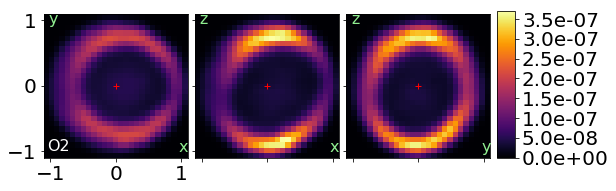

In [262]:
run = 'o2'
froot = dir_root + run + '_out/' + run  
index=12
di = 1 # number of code outputs to use
plt3_heat(froot,index,di,dx,sigz,0,xmax,nsmo_plt3,0.8,-0.1,0,0.1,'O2', run + try_root + 'heatxyz.png')
# this one has thick side away from earth, no density variation
# did not stay aligned, deeper parts hotter

../moon_heat3/o2_out/o2_000012_heat.txt


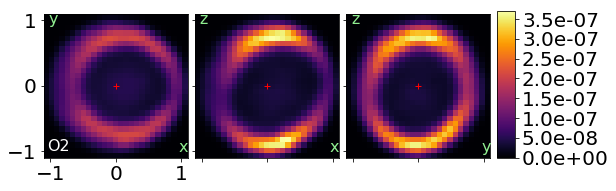

In [261]:
run = 'o2'
froot = dir_root + run + '_out/' + run  
index=12
di = 1 # number of code outputs to use
plt3_heat(froot,index,di,dx,sigz,0,xmax,nsmo_plt3,0.8,-0.1,0.0*np.pi,0.1,'O2', '')
# this one has thick side away from earth, no density variation
# did not stay aligned, deeper parts hotter

In [ ]:
# integrated heating rate is now highest on the thickest side which is away from earth

In [ ]:
# yes I think I can show that the heat map integrated through height
# does not strongly depend on thickness, 
# in other words, the heating rate per unit volume is approximately
# thickness dependent!!!!!!!!!!!!!

In [269]:
np.arange(0,1,0.1)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

../moon_heat3/a2_out/a2_000005_heat.txt


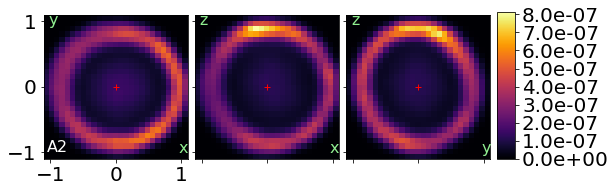

In [299]:
run = 'a2'
froot = dir_root + run + '_out/' + run  
index=5
di = 1 # number of code outputs to use
plt3_heat(froot,index,di,dx,sigz,0,xmax,nsmo_plt3,0.8,-0.1,0.0*np.pi,0.1,'A2', '')
# this one has thick side away from earth, no density variation
# did not stay aligned, deeper parts hotter

../moon_heat3/a2_out/a2_000005_heat.txt


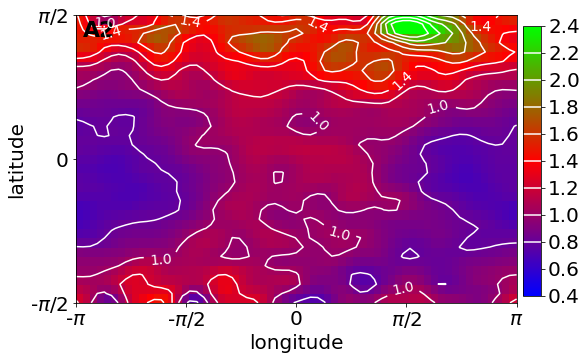

In [300]:
run = 'a2'
froot = dir_root + run + '_out/' + run  
index=5
di=1       # number of code outputs to use
img_m2=plt_heat_ll_img(froot,index,di,dphi,rmin,sigd,nrand,nsmo,'',0.2,0,-0.00)
plt_heat_ll(img_m2,froot,index,di,dphi,rmin,sigd,nrand,nsmo, 1,'A2',run + try_root + '_ll.png')